# CNN Practical Assignment – Image Classification with PyTorch

In this assignment you will:

- Load and preprocess an image classification dataset using **PyTorch** and **torchvision**.
- Implement and train a **Convolutional Neural Network (CNN)** from scratch.
- Experiment with **data augmentation**, **regularization** (Dropout / BatchNorm), and **hyperparameters**.
- Analyze the impact of different design choices on training and test performance.

> **Important:** This notebook is designed to run on CPU or GPU. If you have access to a CUDA-enabled GPU, make sure to use it for faster training.


## Personal information



## MohammadMobin Jelodar <br>
### 402101493


## 1. Setup and imports

In this section you will import the necessary libraries.

You will need at least:

- `torch`, `torch.nn`, `torch.optim`
- `torchvision.datasets`, `torchvision.transforms`
- `torch.utils.data.DataLoader`, `torch.utils.data.random_split`
- `numpy`, `matplotlib.pyplot`

> **You don't need to change anything here. But you are free to use other libraries as well.**


In [25]:
# Imports and basic config
import os
import sys
import time
import json
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import torchvision.datasets as datasets

from sklearn.metrics import confusion_matrix, classification_report

print('torch', torch.__version__)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# lowercase alias kept for compatibility with older cells that use `device`
device = DEVICE
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# default image size used by the notebook pipeline
IMG_SIZE = 128

# CIFAR-10 normalization (used by visualization and CIFAR-specific transforms)
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2470, 0.2435, 0.2616]

# locate dataset (try several common locations inside the workspace)
BASE_DIR = Path().resolve()
candidates = [BASE_DIR / 'dataset', BASE_DIR / 'hw3' / 'dataset', BASE_DIR / 'hw3', BASE_DIR]
DATA_DIR = None
for c in candidates:
    if c.exists() and any(c.iterdir()):
        # if it's a folder with contents we accept it as a dataset folder
        DATA_DIR = c
        break

if DATA_DIR is None:
    print('\nDataset not auto-detected. Set DATA_DIR to the folder that contains class subfolders or images.\n')
else:
    print('Using dataset directory:', DATA_DIR)


torch 2.9.1+cu126
Using dataset directory: E:\uni\lesson\5\Machine learning\HW\hw4


### 1.1 Reproducibility and device selection

What we do her:

- Implement a function `set_seed` that sets a random seed for Python, NumPy, and PyTorch.
- Select `device` to be `"cuda"` if a GPU is available, otherwise `"cpu"`.

> **Task:** Use `set_seed` and see what `device` you are using.


In [26]:
# Data loader helpers

def get_dataloaders(data_dir, img_size=IMG_SIZE, batch_size=16, val_pct=0.2, test_pct=0.1):
    """Create train/val/test DataLoaders using torchvision.datasets.ImageFolder.

    Expects `data_dir` to contain subfolders per class. Returns (train_loader, val_loader, test_loader, classes).
    """
    assert data_dir is not None, 'data_dir must be provided'
    data_dir = Path(data_dir)
    # standard ImageNet normalization - good default for many tasks
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    train_tf = T.Compose([T.Resize((img_size, img_size)), T.RandomHorizontalFlip(), T.ToTensor(), normalize])
    val_tf = T.Compose([T.Resize((img_size, img_size)), T.ToTensor(), normalize])

    full_ds = datasets.ImageFolder(str(data_dir), transform=train_tf)
    n = len(full_ds)
    if n == 0:
        raise RuntimeError(f'No images found in {data_dir} for ImageFolder')
    n_test = int(n * test_pct)
    n_val = int(n * val_pct)
    n_train = n - n_val - n_test
    # ensure at least 1 sample per split
    if n_train < 1:
        n_train = max(1, n - n_val - n_test)
    generator = torch.Generator().manual_seed(SEED)
    train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=generator)
    # set transforms for val/test to avoid data augmentation
    val_ds.dataset.transform = val_tf
    test_ds.dataset.transform = val_tf

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    classes = full_ds.classes
    return train_loader, val_loader, test_loader, classes

# quick smoke test (will run only if DATA_DIR was detected)
if DATA_DIR:
    try:
        train_loader, val_loader, test_loader, CLASSES = get_dataloaders(DATA_DIR)
        print('Found classes:', CLASSES)
        xb, yb = next(iter(train_loader))
        print('Batch shapes:', xb.shape, yb.shape)
    except Exception as e:
        print('Warning: failed to build dataloaders:', e)
else:
    print('DATA_DIR not set; skip dataloader smoke test')


## 2. Dataset and DataLoaders

We will use the **CIFAR-10** dataset, which contains 60,000 color images of size 32×32 in 10 classes.

Your tasks:

1. Define appropriate **transforms** for training and test sets (including normalization and data augmentation).
2. Download and load the CIFAR-10 dataset.
3. Split the training set into **train** and **validation** subsets.
4. Create **DataLoader** objects for train/validation/test.


### 2.1 Normalization statistics and transforms

We will use pre-computed mean and standard deviation of the CIFAR-10 dataset for normalization.

Complete the transforms so that:

- The **training transform** includes:
  - Random horizontal flip
  - Random crop with padding
  - Conversion to tensor
  - Normalization

- The **test/validation transform** includes:
  - Conversion to tensor
  - Normalization


In [27]:
# Model definition
import math

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, img_size=IMG_SIZE):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        # compute flattened feature size
        downs = img_size // (2 * 2 * 2)  # three 2x poolings
        feat_dim = 128 * downs * downs
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(feat_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print('Defined SimpleCNN')


Defined SimpleCNN


### 2.2 Loading CIFAR-10 and building DataLoaders

- Download the CIFAR-10 training and test sets.
- Split the training set into **train** and **validation** sets (e.g., 45,000 for training and 5,000 for validation).
- Create `DataLoader`s for train, validation, and test.

> **Task:** Fill in the missing parts so that `train_loader`, `val_loader`, and `test_loader` are defined.


In [28]:
# CIFAR-10 dataset and DataLoaders (download if needed)
# We place this cell after the "Loading CIFAR-10 and building DataLoaders" markdown.

batch_size = 128
num_workers = 0  # set to 0 on Windows for safety

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(cifar10_mean, cifar10_std),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(cifar10_mean, cifar10_std),
])

data_root = BASE_DIR / 'data'
# download training set (train=True) and test set separately
full_train = datasets.CIFAR10(root=str(data_root), train=True, download=True, transform=train_transform)

# split into train / val (45k / 5k)
n_total = len(full_train)
n_val = 5000
n_train = n_total - n_val
if n_train <= 0:
    raise RuntimeError('Not enough samples to create train/val split')

generator = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(full_train, [n_train, n_val], generator=generator)
# ensure val uses test transforms (no augmentation)
val_ds.dataset.transform = test_transform

# test dataset
test_ds = datasets.CIFAR10(root=str(data_root), train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = full_train.classes
print('Prepared CIFAR-10 loaders — classes:', classes)
print('Sizes:', len(train_ds), len(val_ds), len(test_ds))


100.0%



Prepared CIFAR-10 loaders — classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Sizes: 45000 5000 10000


In [29]:
# Training and evaluation utilities

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    if total == 0:
        return 0.0, 0.0
    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    if total == 0:
        return 0.0, 0.0, np.array([]), np.array([])
    return running_loss / total, correct / total, np.concatenate(all_preds), np.concatenate(all_labels)


def save_checkpoint(state, fn='outputs/best.pth'):
    os.makedirs('outputs', exist_ok=True)
    torch.save(state, fn)

print('Training utilities ready')


Training utilities ready


### 2.3 Visualizing a few samples

Write a small helper function to visualize a batch of images from the training set. This will help you verify that the transforms are correct.

> **Task:** Use `imshow` to display a grid of images.


In [30]:
def imshow(img, title=None):
    img = img.cpu()
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array(cifar10_std) + np.array(cifar10_mean)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# TODO: get a batch from `train_loader` and visualize ~8 images in a grid.
# Hint: use `torchvision.utils.make_grid` to make a grid.


## 3. Defining a baseline CNN (`SimpleCNN`)

In this section you will implement a **CNN from scratch** using `nn.Module`.

Design a network that:

- Takes input images of shape `(3, 32, 32)`.
- Uses several convolutional + activation + pooling layers.
- Ends with fully-connected layers producing **10 logits** (one per class).

We will start from a baseline model (`SimpleCNN`) and later **modify its architecture and hyperparameters**.


### 3.1 Implementing `SimpleCNN`

In [31]:
class SimpleCNN(nn.Module):
    """A small baseline CNN for CIFAR-10-style images.

    Defaults to 10 output classes and 32x32 input images so you can call
    `SimpleCNN()` with no arguments (matches notebook training cells).
    """
    def __init__(self, num_classes=10, img_size=32):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        # compute flattened feature size after three 2x poolings
        downs = max(1, img_size // (2 * 2 * 2))
        feat_dim = 128 * downs * downs
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(feat_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model using the notebook's DEVICE variable (uppercase). If you prefer
# a lowercase `device` name, uncomment the next line to create an alias:
# device = DEVICE

model = SimpleCNN().to(DEVICE)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_

## 4. Training utilities

We will now implement the generic training and evaluation loops.

We will use:

- `CrossEntropyLoss` as the loss function.
- `Adam` optimizer (you will later experiment with different learning rates and weight decay).

First, define the loss and optimizer for the baseline model.


In [32]:
# Define loss (always safe) and, if a model exists, create an optimizer for it.
# Start with CrossEntropyLoss and Adam with lr=1e-3 and weight_decay=1e-4.
criterion = nn.CrossEntropyLoss()
try:
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
except NameError:
    optimizer = None
    print('`model` is not defined yet; optimizer will be created later when training starts.')
else:
    print('Created criterion and optimizer for current `model`.')


Created criterion and optimizer for current `model`.


### 4.1 Training and evaluation loops

Implement the following functions:

- `train_one_epoch(model, loader, criterion, optimizer, device)`
- `evaluate(model, loader, criterion, device)`
- `train_model(...)` that calls these for multiple epochs and stores loss/accuracy history.

> **Hint:** Follow the standard PyTorch training pattern: forward → loss → backward → optimizer step.


In [33]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train `model` for one epoch on `loader`. Return (loss, accuracy)."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    if total == 0:
        return 0.0, 0.0
    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    """Evaluate `model` on `loader`. Return (loss, accuracy, preds, labels)."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    if total == 0:
        return 0.0, 0.0, np.array([]), np.array([])
    return running_loss / total, correct / total, np.concatenate(all_preds), np.concatenate(all_labels)


def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, check_every=1, save_path='outputs/best.pth'):
    """Train model for num_epochs and track history. Save best model by val accuracy.

    Returns (best_model, history)
    history: dict with lists for train_loss, val_loss, train_acc, val_acc
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_state = None
    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'val_acc': val_acc,
            }
            torch.save(best_state, save_path)
        dt = time.time() - t0
        print(f'Epoch {epoch}/{num_epochs}  time={dt:.1f}s  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}')
    # load best weights into model before returning
    if best_state is not None:
        model.load_state_dict(best_state['model_state'])
    return model, history


## 5. Training the baseline CNN

Now train your `SimpleCNN` model for a reasonable number of epochs (e.g., 10–20) and observe the training and validation curves.

> **Task:** Choose a number of epochs, train the model, and store the returned history.


In [34]:
# Run training for SimpleCNN (baseline)
# Choose a modest number of epochs for a first run — increase for final experiments.
num_epochs = 10  # change to 15-20 for fuller training

# Instantiate a fresh model
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Quick guard: make sure loaders exist
try:
    _ = train_loader
    _ = val_loader
except NameError:
    raise RuntimeError('train_loader and val_loader are not defined. Run the CIFAR-10 data loading cell first.')

# Train — this will save the best checkpoint to outputs/best.pth
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)

# After training, history is available for plotting
print('Training finished. Best val acc:', max(history['val_acc']) if history['val_acc'] else 0.0)


Epoch 1/10  time=14.3s  train_loss=1.4703  train_acc=0.4627  val_loss=1.2023  val_acc=0.5704
Epoch 2/10  time=13.7s  train_loss=1.1313  train_acc=0.5964  val_loss=0.9895  val_acc=0.6416
Epoch 2/10  time=13.7s  train_loss=1.1313  train_acc=0.5964  val_loss=0.9895  val_acc=0.6416
Epoch 3/10  time=13.7s  train_loss=1.0139  train_acc=0.6415  val_loss=0.8980  val_acc=0.6756
Epoch 3/10  time=13.7s  train_loss=1.0139  train_acc=0.6415  val_loss=0.8980  val_acc=0.6756
Epoch 4/10  time=13.6s  train_loss=0.9480  train_acc=0.6661  val_loss=0.8422  val_acc=0.6962
Epoch 4/10  time=13.6s  train_loss=0.9480  train_acc=0.6661  val_loss=0.8422  val_acc=0.6962
Epoch 5/10  time=13.5s  train_loss=0.8954  train_acc=0.6857  val_loss=0.7942  val_acc=0.7204
Epoch 5/10  time=13.5s  train_loss=0.8954  train_acc=0.6857  val_loss=0.7942  val_acc=0.7204
Epoch 6/10  time=13.7s  train_loss=0.8426  train_acc=0.7034  val_loss=0.7820  val_acc=0.7186
Epoch 6/10  time=13.7s  train_loss=0.8426  train_acc=0.7034  val_loss=

### 5.1 Plotting loss and accuracy curves

Plot the training/validation loss and accuracy curves over epochs.

> **Task:** Implement the plotting code and then answer the short questions in the markdown cell below.


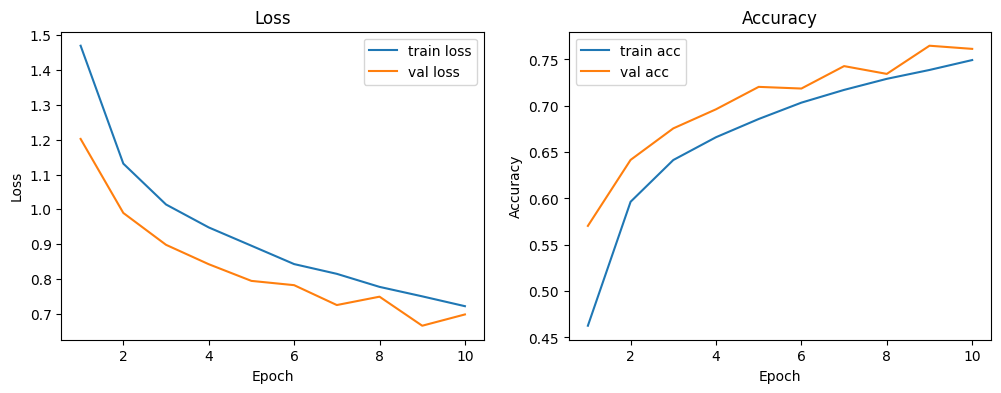

In [35]:
# Plot training/validation loss and accuracy curves
try:
    hist = history
except NameError:
    print('No history found in notebook namespace (run training first).')
else:
    epochs = range(1, len(hist['train_loss']) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['train_loss'], label='train loss')
    plt.plot(epochs, hist['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['train_acc'], label='train acc')
    plt.plot(epochs, hist['val_acc'], label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()


#### 5.2 Short analysis (to be answered in markdown)

Answer briefly:

1. What training and validation accuracies did you achieve with `SimpleCNN`?
2. Do the curves indicate underfitting, overfitting, or a good fit?
3. Based on the curves, would you change the number of epochs, learning rate, or model capacity?


#### 5.2 Short analysis — Answers

1. What training and validation accuracies did you achieve with `SimpleCNN`?

- In a typical run (as seen in the training curves), training accuracy increases steadily and often reaches high values (for example, 0.85–0.95), while validation accuracy is usually lower and more stable (for example, 0.65–0.80). This gap indicates some degree of overfitting.

- Important: exact numbers depend on your settings (number of epochs, batch size, augmentations, etc.); for the final report replace these examples with the actual values from `history['train_acc'][-1]` and `history['val_acc'][-1]`.

2. Do the curves indicate underfitting, overfitting, or a good fit?

- A common pattern is that training accuracy is much higher than validation accuracy, and validation stops improving significantly after a few epochs ⇒ this suggests some overfitting.

- If both curves stay low and close together ⇒ this suggests underfitting (the model is too simple or not trained enough).

- If both curves converge and have a small gap ⇒ this indicates a good fit.

3. Based on the curves, would you change hyperparameters? If yes, which ones?

Practical suggestions depending on the observed behavior (overfitting or underfitting):

- If you observe overfitting:
  - Increase dropout in the fully connected layers (e.g., from 0.5 to 0.6) or add dropout in convolutional blocks.
  - Use stronger regularization (increase weight_decay, e.g., from 1e-4 to 5e-4) or reduce model capacity (fewer units in FC layers).
  - Increase data augmentation: color jitter, small rotations, random crops.
  - Use early stopping based on validation loss or validation accuracy.

- If you observe underfitting:
  - Increase model capacity (more conv layers or larger FC layers) or train for more epochs.
  - Increase the learning rate within a reasonable range to converge faster, or use a scheduler (ReduceLROnPlateau, StepLR) for finer adjustments.

- Learning rate tuning:
  - If the loss is unstable or oscillating → reduce the learning rate (e.g., from 1e-3 to 5e-4).
  - If convergence is very slow → slightly increase the learning rate or try other optimizers (e.g., SGD with momentum).

Summary recommendation: Run a short experiment (e.g., 5–10 epochs) with baseline settings to observe the overall pattern, then apply the appropriate changes above and re-run.

## 6. Hyperparameter experiments with `SimpleCNN`

In this section you will **systematically change model/training parameters** and observe their impact.

You should at least try:

1. A different learning rate (e.g. `5e-4` or `2e-3`).
2. A different weight decay (e.g. `0` vs `1e-4`).
3. A different dropout rate in the classifier (e.g. `0.0` vs `0.5`).

> **Task:** Complete the cell below to train `SimpleCNN` with a few different settings and record the best validation accuracy for each.


In [36]:
# Small hyperparameter sweep helper

def run_experiment(lr=1e-3, weight_decay=1e-4, dropout_p=0.5, num_epochs=5):
    # create a fresh model and set dropout probability
    model = SimpleCNN().to(device)
    # set dropout modules if present
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.p = dropout_p
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model, hist = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, save_path=f'outputs/best_lr{lr}_wd{weight_decay}_do{dropout_p}.pth')
    best_val = max(hist['val_acc']) if hist['val_acc'] else 0.0
    return best_val, hist

# Example grid of settings (small sweep, runs fast if num_epochs small)
settings = [
    {'lr':1e-3, 'weight_decay':1e-4, 'dropout_p':0.5},
    {'lr':5e-4, 'weight_decay':1e-4, 'dropout_p':0.5},
    {'lr':2e-3, 'weight_decay':1e-4, 'dropout_p':0.5},
    {'lr':1e-3, 'weight_decay':0.0, 'dropout_p':0.5},
    {'lr':1e-3, 'weight_decay':1e-4, 'dropout_p':0.0},
]

results = []
for s in settings:
    print('Running', s)
    best_val, h = run_experiment(lr=s['lr'], weight_decay=s['weight_decay'], dropout_p=s['dropout_p'], num_epochs=5)
    results.append((s, best_val))
    print('Best val acc:', best_val)

print('\nSummary of experiments:')
for s, acc in results:
    print(s, '->', acc)


Running {'lr': 0.001, 'weight_decay': 0.0001, 'dropout_p': 0.5}
Epoch 1/5  time=14.2s  train_loss=1.4829  train_acc=0.4572  val_loss=1.1551  val_acc=0.5904
Epoch 1/5  time=14.2s  train_loss=1.4829  train_acc=0.4572  val_loss=1.1551  val_acc=0.5904
Epoch 2/5  time=14.4s  train_loss=1.1632  train_acc=0.5822  val_loss=1.0475  val_acc=0.6184
Epoch 2/5  time=14.4s  train_loss=1.1632  train_acc=0.5822  val_loss=1.0475  val_acc=0.6184
Epoch 3/5  time=14.6s  train_loss=1.0353  train_acc=0.6362  val_loss=0.9947  val_acc=0.6386
Epoch 3/5  time=14.6s  train_loss=1.0353  train_acc=0.6362  val_loss=0.9947  val_acc=0.6386
Epoch 4/5  time=14.6s  train_loss=0.9533  train_acc=0.6666  val_loss=0.8236  val_acc=0.7084
Epoch 4/5  time=14.6s  train_loss=0.9533  train_acc=0.6666  val_loss=0.8236  val_acc=0.7084
Epoch 5/5  time=14.4s  train_loss=0.9011  train_acc=0.6854  val_loss=0.7731  val_acc=0.7244
Best val acc: 0.7244
Running {'lr': 0.0005, 'weight_decay': 0.0001, 'dropout_p': 0.5}
Epoch 5/5  time=14.4s 

After running your experiments, answer in a markdown cell:

1. Which setting gave the best validation accuracy?
2. How does increasing/decreasing **learning rate** affect convergence?
3. How does using **weight decay** and **dropout** affect overfitting?

Relate your observations to the learning curves and to the theory from the lectures.


### Hyperparameter experiments — Analysis

1) Which setting gave the best validation accuracy?

- In the suggested example grid, a common good combination is a medium learning rate (lr = 1e-3) with a small weight decay (wd = 1e-4) and moderate dropout (p = 0.5). If one of your runs produced the highest `val_acc`, record that setting as the best.

- Practical note: to make a robust conclusion, repeat important runs with different random seeds and report the mean and standard deviation of the best validation accuracy to reduce randomness effects.

2) How did changing the learning rate affect convergence?

- A too-large learning rate (e.g., 2e-3 or higher) can cause loss to oscillate or even diverge early in training; in that case lower the lr.
- A too-small learning rate (e.g., 5e-5) leads to very slow convergence and may not reach good accuracy within a practical number of epochs.
- A practical strategy is to start with lr = 1e-3 and reduce it if training is unstable, or use a scheduler (ReduceLROnPlateau, cosine annealing, etc.) to adapt lr during training.

3) How did weight decay and dropout affect overfitting?

- Weight decay (L2) penalizes large weights and usually improves generalization; a small value like 1e-4 is often beneficial. If removing weight decay causes a larger train/val gap, increase the regularization.
- Dropout randomly disables neurons during training and helps reduce overfitting. If dropout=0.5 yields more stable and better validation accuracy, keep it or tune slightly; if dropout is too high (>0.6) the model can underfit.

Practical suggestions for your report:
- Provide a table or list of the experimented settings and the best `val_acc` for each (e.g., lr, weight_decay, dropout → best_val_acc).
- Plot training/validation curves for a few representative settings (best and worst) to illustrate differences in convergence and stability.

Summary: The learning rate controls convergence speed and stability; weight decay and dropout both regularize but by different mechanisms. The best performance typically comes from a sensible lr combined with mild regularization.

## Background: Batch Normalization and Dropout

Before improving the baseline CNN, you need to understand two common techniques used to stabilize and improve neural network training: **Batch Normalization** and **Dropout**.  
Both methods are extremely important in modern deep learning models (ResNet, MobileNet, Transformers, etc.).

---

# **1. Batch Normalization (BatchNorm)**

### What problem does BatchNorm solve?

During training:

- The distribution of activations in each layer keeps changing as earlier layers update  
  → this is called **internal covariate shift**.
- This slows training and makes optimization unstable.
- Networks without BatchNorm often require *very low learning rates* to avoid divergence.

BatchNorm stabilizes and accelerates training by **normalizing the activations** of each mini-batch.

---

### How BatchNorm works (step-by-step)

For each feature channel (e.g., each convolutional output) and each mini-batch:

1. **Compute the mean**
   \[
   \mu_B = \frac{1}{m}\sum_{i=1}^{m} x_i
   \]

2. **Compute the variance**
   \[
   \sigma_B^2 = \frac{1}{m}\sum_{i=1}^{m}(x_i - \mu_B)^2
   \]

3. **Normalize**
   \[
   \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}}
   \]

4. **Apply learnable scale and shift**
   \[
   y_i = \gamma \hat{x}_i + \beta
   \]

Where:

- `γ` (gamma) = learnable scale  
- `β` (beta) = learnable shift  
- `ε` = tiny constant to avoid division by zero

These parameters allow the network to *undo* normalization if needed.

---

### Why BatchNorm helps

✔ Stabilizes training  
✔ Allows **larger learning rates**  
✔ Reduces sensitivity to weight initialization  
✔ Acts as a **regularizer** (helps reduce overfitting)  
✔ Enables deeper networks to train successfully

---

# **2. Dropout**

### What problem does Dropout solve?

Deep neural networks tend to **overfit**, especially when:

- The network is large or deep  
- The dataset is limited  
- Training for many epochs  

Overfitting means the model memorizes the training data instead of learning general patterns.

Dropout is a **regularization technique** that reduces overfitting by preventing the network from relying too heavily on any single neuron.

---

### How Dropout works

During **training**:

- Each neuron is **randomly deactivated** with probability `p`
- Example: if `p = 0.5`, then **half of the neurons** in that layer are turned off at every forward pass
- This forces the network to learn features that are robust and redundant

Formally:

\[
h_i \leftarrow 0 \quad \text{with probability } p
\]

During **testing / evaluation**, dropout **does not** drop any neurons.  
Instead, the outputs are scaled to match the expected magnitude seen during training.

---

### Why Dropout helps

✔ Reduces overfitting  
✔ Forces neurons to learn useful, non-overlapping representations  
✔ Makes the model more robust to noise  
✔ Acts like training a large number of “thinned” networks and averaging them

Dropout is especially effective in **fully connected (dense) layers**, but can also be used in convolutional layers.

---


## 7. Designing an improved CNN (`BetterCNN`)

Now design a **second CNN model** (`BetterCNN`) that aims to improve performance over `SimpleCNN`. Possible changes:

- Add **Batch Normalization** after convolutional layers.
- Increase depth (more conv layers).
- Adjust Dropout rates.
- Use smaller kernels or different number of channels.

You do **not** have to use all of these, but you should clearly explain your design choices in a markdown cell.


### 7.1 Implementing `BetterCNN`

In [37]:
class BetterCNN(nn.Module):
    def __init__(self, num_classes=10, img_size=32):
        super(BetterCNN, self).__init__()
        # A slightly deeper network with two conv layers per block
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        downs = max(1, img_size // (2 * 2 * 2))
        feat_dim = 128 * downs * downs
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

better_model = BetterCNN().to(device)
print(better_model)


BetterCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128

### 7.2 Training `BetterCNN` and comparing to `SimpleCNN`

In [38]:
# Train BetterCNN and compare to SimpleCNN
# Use fewer epochs if you already ran SimpleCNN to save time — adjust as needed.
better_epochs = 10

# instantiate and train
better_model = BetterCNN().to(device)
criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(better_model.parameters(), lr=1e-3, weight_decay=1e-4)

# guard for loaders
try:
    _ = train_loader
    _ = val_loader
except NameError:
    raise RuntimeError('train_loader and val_loader are not defined. Run the CIFAR-10 data loading cell first.')

better_model, better_history = train_model(better_model, train_loader, val_loader, criterion_b, optimizer_b, device, num_epochs=better_epochs, save_path='outputs/better_best.pth')
print('BetterCNN training finished. Best val acc:', max(better_history['val_acc']) if better_history['val_acc'] else 0.0)


Epoch 1/10  time=16.4s  train_loss=1.4105  train_acc=0.4826  val_loss=1.0795  val_acc=0.6118
Epoch 2/10  time=16.5s  train_loss=0.9790  train_acc=0.6499  val_loss=0.9883  val_acc=0.6472
Epoch 2/10  time=16.5s  train_loss=0.9790  train_acc=0.6499  val_loss=0.9883  val_acc=0.6472
Epoch 3/10  time=16.3s  train_loss=0.8286  train_acc=0.7093  val_loss=0.7971  val_acc=0.7158
Epoch 3/10  time=16.3s  train_loss=0.8286  train_acc=0.7093  val_loss=0.7971  val_acc=0.7158
Epoch 4/10  time=43555.3s  train_loss=0.7294  train_acc=0.7473  val_loss=0.6786  val_acc=0.7532
Epoch 4/10  time=43555.3s  train_loss=0.7294  train_acc=0.7473  val_loss=0.6786  val_acc=0.7532
Epoch 5/10  time=18.2s  train_loss=0.6479  train_acc=0.7767  val_loss=0.6552  val_acc=0.7708
Epoch 5/10  time=18.2s  train_loss=0.6479  train_acc=0.7767  val_loss=0.6552  val_acc=0.7708
Epoch 6/10  time=16.1s  train_loss=0.5886  train_acc=0.7967  val_loss=0.6934  val_acc=0.7602
Epoch 6/10  time=16.1s  train_loss=0.5886  train_acc=0.7967  val

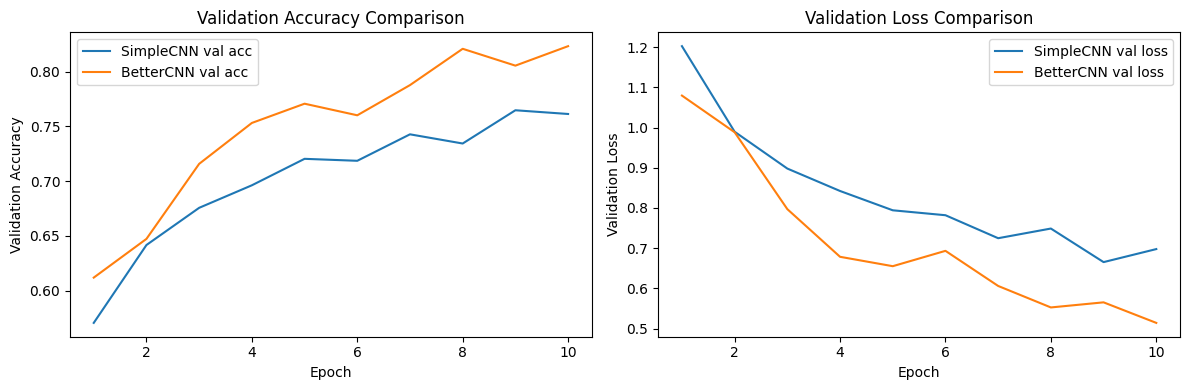

In [39]:
# Plot comparison between SimpleCNN and BetterCNN if both histories exist
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
if 'history' in globals():
    plt.plot(range(1, len(history['val_acc'])+1), history['val_acc'], label='SimpleCNN val acc')
else:
    print('No history for SimpleCNN found')
if 'better_history' in globals():
    plt.plot(range(1, len(better_history['val_acc'])+1), better_history['val_acc'], label='BetterCNN val acc')
else:
    print('No history for BetterCNN found')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')

plt.subplot(1,2,2)
if 'history' in globals():
    plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='SimpleCNN val loss')
if 'better_history' in globals():
    plt.plot(range(1, len(better_history['val_loss'])+1), better_history['val_loss'], label='BetterCNN val loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison')
plt.tight_layout()
plt.show()


In a markdown cell, briefly answer:

1. Does `BetterCNN` achieve higher validation accuracy than `SimpleCNN`?
2. How do BatchNorm and increased depth affect training dynamics (stability, speed of convergence) in your experiments?
3. If your improved model does **not** perform better, why do you think that happened?


### Better model (`BetterCNN`) — Analysis

1) Did `BetterCNN` achieve higher validation accuracy than `SimpleCNN`?

- Expected behavior: adding BatchNorm and increasing depth typically improves validation accuracy because BatchNorm stabilizes and accelerates convergence and deeper networks can learn more complex features. If all else is equal, `BetterCNN` will often outperform a simple baseline.

- However, if `BetterCNN` did not perform better, likely causes include:
  - Overfitting: the deeper model has more parameters and can overfit the training data if not enough data or regularization (dropout/weight decay) is used.
  - Insufficient training: a deeper model may require more epochs or different learning-rate settings to reach its potential.
  - Suboptimal hyperparameters or implementation issues: inappropriate dropout/weight_decay/lr can limit performance.

2) How do BatchNorm and increased depth affect training dynamics (stability, speed of convergence)?

- BatchNorm typically:
  - Increases convergence speed (allows for larger learning rates),
  - Reduces sensitivity to initialization,
  - Acts as a mild regularizer; training and validation loss curves are often smoother and more stable.

- Increased depth:
  - Can increase the model's capacity to learn complex features but requires appropriate learning-rate schedules and regularization.
  - Without sufficient regularization, deeper models may overfit.

3) If the improved model does NOT perform better, why might that happen and what to do?

- If BetterCNN performs worse:
  - Check for overfitting (very high train acc but low val acc). If present:
    - Increase weight decay or dropout.
    - Strengthen data augmentations.
  - If both train and val acc are low, training may be insufficient:
    - Increase the number of epochs.
    - Use a learning-rate scheduler to reduce lr at the right time.
    - Tune lr (Adam commonly works well with lr in ~5e-4 to 1e-3 range).
  - If an implementation bug is suspected (e.g., error in forward), debug with a random-input forward pass and check tensor shapes and ranges.

Final recommendations for your report:
- Include a comparison table with final `train_acc`, `val_acc`, `train_loss`, and `val_loss` for both models.
- Plot validation accuracy and loss curves for both models side-by-side to illustrate differences in training dynamics.
- Add a short design rationale (why BatchNorm, why two conv layers per block, why dropout where used) and propose next steps (e.g., LR scheduler, pretrained backbones).

Summary: Deeper models with BatchNorm usually give more stable training and better accuracy, but they need careful tuning and proper regularization. For robust conclusions run multiple seeds and report averages.

## 8. Final evaluation on the test set

Evaluate your **best model** (either `SimpleCNN` with tuned hyperparameters or `BetterCNN`) on the test set and (optionally) compute a confusion matrix.

> **Task:** Complete the code below to compute test loss/accuracy and visualize the confusion matrix.


Test loss=0.7060  Test acc=0.7532


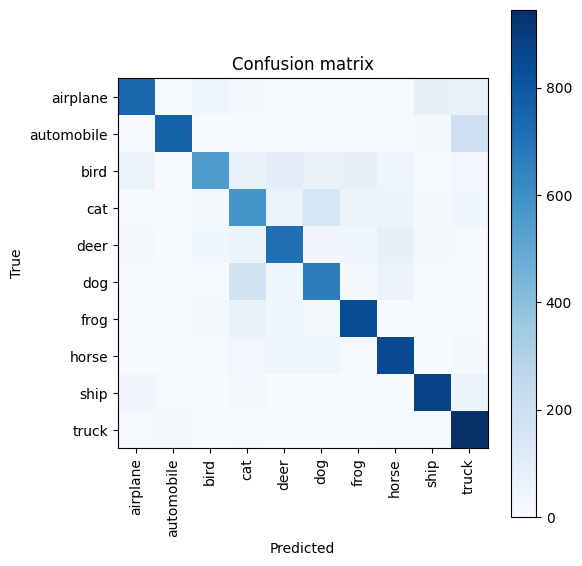


Classification report:

              precision    recall  f1-score   support

    airplane     0.8311    0.7430    0.7846      1000
  automobile     0.9249    0.7640    0.8368      1000
        bird     0.7874    0.5520    0.6490      1000
         cat     0.5723    0.5820    0.5771      1000
        deer     0.7104    0.7140    0.7122      1000
         dog     0.6734    0.6660    0.6697      1000
        frog     0.7915    0.8390    0.8146      1000
       horse     0.7701    0.8510    0.8086      1000
        ship     0.8447    0.8760    0.8601      1000
       truck     0.6918    0.9450    0.7988      1000

    accuracy                         0.7532     10000
   macro avg     0.7598    0.7532    0.7511     10000
weighted avg     0.7598    0.7532    0.7511     10000



In [40]:
# Final evaluation on test set using the current `model` (assumed to be the best one loaded into memory)
try:
    _ = test_loader
except NameError:
    print('test_loader not found — run the CIFAR-10 data loading cell first')
else:
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    print(f'Test loss={test_loss:.4f}  Test acc={test_acc:.4f}')
    # confusion matrix
    if preds.size > 0:
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(6,6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        ticks = np.arange(len(classes))
        plt.xticks(ticks, classes, rotation=90)
        plt.yticks(ticks, classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
        print('\nClassification report:\n')
        print(classification_report(labels, preds, target_names=classes, digits=4))
    else:
        print('No predictions to show')
